In [1]:
print("Hello world")

Hello world


# Exercise 1

In [18]:
from pyod.utils.data import generate_data

X_train, X_test, y_train, y_test = generate_data(n_train=400, n_test=100, n_features=2, contamination=0.1, random_state=12)

In [19]:
X_train[:, 0].shape

(400,)

In [20]:
y_train.shape

(400,)

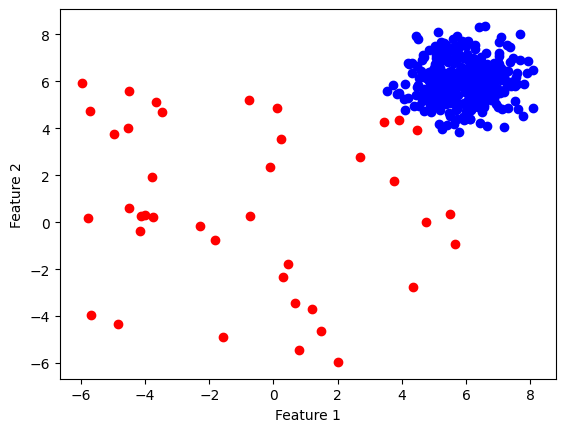

In [21]:
import matplotlib.pyplot as plt

plt.scatter(X_train[:, 0][y_train == 0], X_train[:, 1][y_train == 0], color='b')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.scatter(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], color='r')
plt.show()


# Exercise 2

In [22]:
from pyod.models.knn import KNN

knn = KNN(contamination=0.1)

knn.fit(X_train)

anomaly_train_scores = knn.decision_scores_
anomaly_test_scores = knn.decision_function(X_test)

In [23]:
anomaly_train_scores[:20]

array([0.18923729, 0.13814194, 0.11943638, 0.29754968, 0.21332228,
       0.12505266, 0.18004112, 0.20467976, 0.22156557, 0.16753956,
       0.16695949, 0.17367782, 0.22675964, 0.49748851, 0.25629847,
       0.16019006, 0.1913622 , 0.25229014, 0.69840275, 0.24998041])

In [24]:
anomaly_test_scores[:20]

array([0.28796466, 0.13325371, 0.18605042, 0.12698836, 0.35376335,
       0.13211873, 0.22656933, 0.19845532, 0.17461429, 0.61827958,
       0.19978008, 0.23150378, 0.44217102, 0.18749911, 0.11556604,
       0.18121394, 0.2718412 , 0.20719553, 0.36696655, 0.19316613])

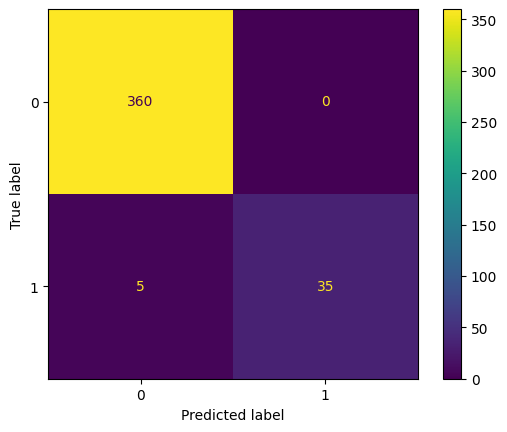

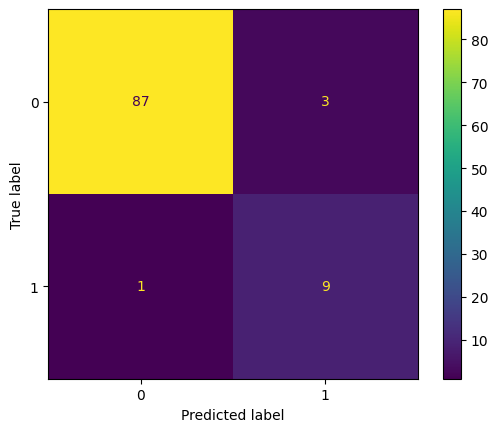

In [25]:
#calculate TP, TN, FP, FN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_train = knn.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()

plt.show()

y_pred_test = knn.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()

plt.show()

In [26]:
def balanced_accuracy(cm: confusion_matrix) -> float:
    TN, FP, FN, TP = cm.ravel()
    TPR = (TP / (TP + FN))
    TNR = (TN / (TN + FP))

    BA = (TPR + TNR) / 2
    return BA

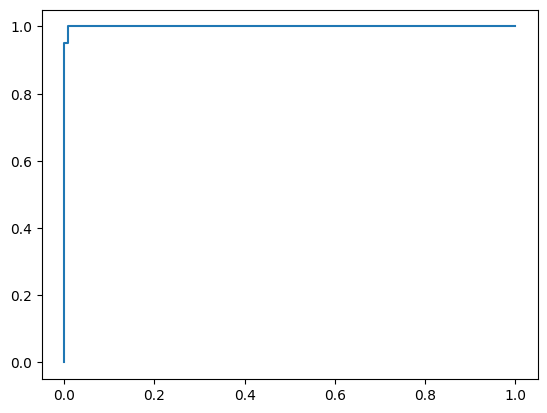

0.9375


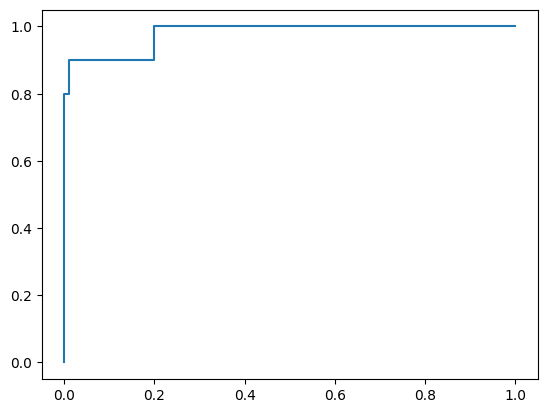

0.9333333333333333


In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, anomaly_train_scores)
plt.plot(fpr, tpr)
plt.show()
print(balanced_accuracy(cm_train))

fpr, tpr, thresholds = roc_curve(y_test, anomaly_test_scores)
#plot ROC curve
plt.plot(fpr, tpr)
plt.show()
print(balanced_accuracy(cm_test))

## Need to change contamination rate!

# Exercise 3

In [28]:
X_train, _, y_train, _ = generate_data(n_train=1000, n_test=0, n_features=1, contamination=0.1, random_state=12)

In [29]:
import numpy as np
μ = np.mean(X_train)
σ = np.std(X_train)

def z_score(x: np.array, μ: np.double, σ: np.double) -> np.array:
    return (x - μ) / σ

z_scores = z_score(X_train, μ, σ)

In [30]:
z_score_threshold = np.quantile(z_scores, 0.90)
z_score_threshold

0.7227890273386918

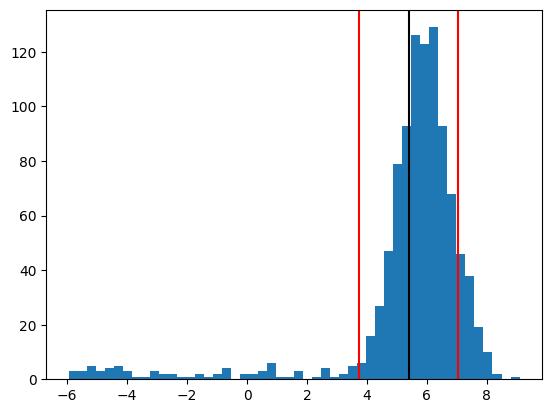

In [31]:
# draw 2 vertical lines to show the threshold
plt.axvline(x= μ + z_score_threshold * σ, color='r')
plt.axvline(x= μ - z_score_threshold * σ, color='r')
plt.axvline(x= μ, color='black')
plt.hist(X_train, bins=50)
plt.show()

In [32]:
# Select data points within the range
y_pred_train = np.where((X_train >= μ - z_score_threshold * σ) & (X_train <= μ + z_score_threshold * σ), 0, 1)
cm_train = confusion_matrix(y_train, y_pred_train)

In [33]:
balanced_accuracy(cm_train)

0.8177777777777777

# Exercise 4

In [187]:
# we need to generate Σ. We can do this by generating a random matrix and then multiplying it by its transpose to make it symmetric. 
# The resulting matrix will be positive semi-definite, which is a requirement for a covariance matrix.


d: np.int32 = 2

Σ = np.random.rand(d, d)
Σ = np.dot(Σ, Σ.T)

μ = np.random.rand(d)
L = np.linalg.cholesky(Σ)

no_points: np.int32 = 1000

x = np.random.multivariate_normal(np.zeros(d), np.eye(d), no_points)


x_new = L @ x.T + μ[:, np.newaxis]


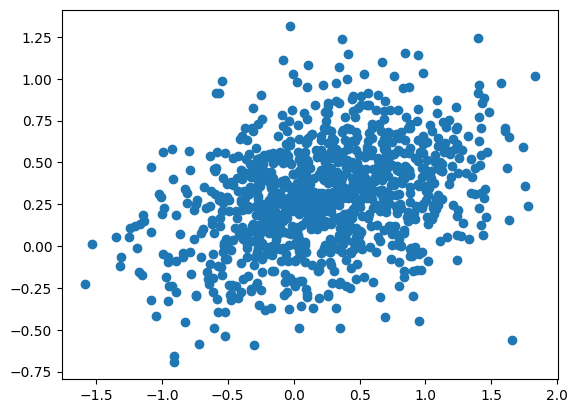

In [188]:
plt.scatter(x_new[0], x_new[1])


In [189]:
from scipy.linalg import solve_triangular

def z_score_multivariate(x: np.array, μ: np.array, Σ: np.array) -> np.array:
    x_bar = (x - μ[:, np.newaxis])
    L = np.linalg.cholesky(Σ)   
    print(L.shape)
    y = solve_triangular(L, x_bar, lower=True)

    v = []

    for k in range(x.shape[1]):
        v.append(y[:, k] @ y[:, k].T)

    return v



In [190]:
z_scores = z_score_multivariate(x_new, μ, Σ)
z_score_threshold = np.quantile(z_scores, 0.90)
z_score_threshold

(2, 2)


4.565362143379962

In [191]:
X_train, _, y_train, _ = generate_data(n_train=1000, n_test=0, n_features=d, contamination=0.1, random_state=12)

μ = X_train.mean(axis=0)
Σ = np.cov(X_train, rowvar=False)

z_scores = z_score_multivariate(X_train.T, μ, Σ)
z_score_threshold = np.quantile(z_scores, 0.90)

(2, 2)


In [192]:
y_pred = np.where(z_scores > z_score_threshold, 0, 1)

In [193]:
cm_train = confusion_matrix(y_train, y_pred_train)

In [194]:
balanced_accuracy(cm_train)

0.8177777777777777